<a href="https://colab.research.google.com/github/lschmiddey/deep_q_learning/blob/master/deep_q_learning_dynamic_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea 

This notebook is based on this blogpost: https://blog.griddynamics.com/deep-reinforcement-learning-for-supply-chain-and-price-optimization/

In this notebook we take the idea from the above mentioned blogpost and extend it to make it more realistic. The main idea is that we have an estimated demand function, so we know the relation between price and demand. We then use Deep Reinforcement Learning, to learn the best price pattern. We also add another dimension, not often modelled so far: the available stock. This notebook explicitly takes the availabke stock into the demand function and optimizes via Reinforcement Learning to get the best price pattern given these circumstances.

# Imports

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from matplotlib import animation, rc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Environment

We take a simple linear demand function, dependent on the current price and the price from the last period.

Nachfrage = plus(q_0 - k * p_t - a * shock(plus(p_t - p_t_1)) + b * shock(minus(p_t - p_t_1)))

We also make the demand dependent on how much stock is still available.

In [31]:
## Environment simulator
def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)


# Demand at time step t for current price p_t and previous price p_t_1
# def q_t(s0, k, p_t, p_t_1, st):
#     return min(plus((s0-k*p_t)*(1-(p_t-max(p_t_1, 1))/max(p_t_1, 1))), st)

def q_t(q0, k, p_t, p_t_1, st):
    return plus(min(plus(q0 - k*p_t - shock(plus(p_t - p_t_1)) + shock(minus(p_t - p_t_1))), st))

# Profit at time step t
def profit_t(q0, k, p_t, p_t_1, st, unit_cost):
    return q_t(q0, k, p_t, p_t_1, st)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q0, k, st):
    return profit_t(q0, k, p[0], p[0], st, unit_cost) + sum(map(lambda t: profit_t(q0, k, p[t], p[t-1], st, unit_cost), range(len(p))))

## Environment parameters

# for how many days do we want to estimate the best price pattern
T = 14

# our price range for the article
price_max = 20
price_min = 5
price_step = 1

# our (totally made up) demand function
q0 = 180
st = 40
k = 12
unit_cost = 6

## Partial bindings for readability
def q_t_response(p_t, p_t_1, stock):
    return q_t(q0, k, p_t, p_t_1, stock)
    
def profit_t_response(p_t, p_t_1, stock):
    return profit_t(q0, k, p_t, p_t_1, stock, unit_cost)

def profit_response(p, stock):
    return profit_total(p, unit_cost, q0, k, stock)


Profit visualisieren:

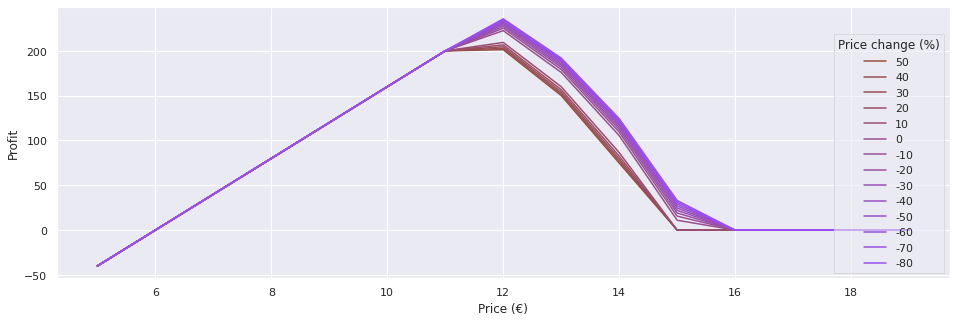

In [32]:
## Visualize price-demand functions (for visualization we assume a constant available stock like the blog post does completely)
price_grid = np.arange(price_min, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j], stock=40)

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'red'
    else:
        color = (0.6, 0.3, price_change_grid[i]/2.0)
        plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price (€)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1-price_change_grid)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)

On the x-axis we see the price, the y-axis represents our demand for the given price. We set the minimal price to 1 and the maximal price to 10 (which is realistic, because most companies do not want the price range to be too big). 

Auf der x-Achse ist der Preis abgebildet, auf der y-Achse der Gewinn. Da wir angenommen haben, die Kosten liegen bei 10€ pro Stück, sind wir bei einem Preis von 10€ bei einem Gewinn von 0€. Wir haben außerdem bestimmte Annahmen über das User-Verhalten getroffen, sprich, ab einem gewissen Preis kauft niemand mehr das Kleidungsstück.

Wir wollen jetzt die optimale Preis-Response Funktion schätzen. Dies tun wir mit Hilfe von einem Deep Q-Learning.

# Helper Funktionen für Visualisierung

In [33]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Gewinn (€)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

# Pricing Policy mit Deep Q-Learning

In [34]:
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'stock', 'next_stock'))

Hier legen wir die Basis für die schon bekannten state, action, next_state und reward 

In [36]:
# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Aufeinander folgende Sequenzen sind logischerweise stark miteinander korreliert. Um diese Korrelation nicht ins Modell mit einfließen zu lassen, nutzen wir das Replay Memory. Hierbei speichern wir in jedem TimeStep den state, action, next_state und reward des Agenten. Dann samplen wir aus diesem Replay Memory, um das Modell zu trainieren. 

In [37]:
class PolicyNetworkDQN_custom(nn.Module):
    def __init__(self, state_size, action_size, H1=128, H2=32, H3=218):
        super(PolicyNetworkDQN_custom, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(state_size, H1) 
        self.layer_2 = nn.Linear(H1, H1)
        self.layer_3 = nn.Linear(H1, H2)
        self.layer_4 = nn.Linear(H2, H3)
        self.layer_out = nn.Linear(H3, action_size) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

Hier bauen wir ein sehr einfaches DeepLearning Modell. Es besteht aus 4 hidden Layern, alle mit 128 Knotenpunkten. Der Input ist die State_size, der Output die action_size. 

In [38]:
class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

Hier definieren wir den TradeOff von explore vs exploit. Dabei starten wir mit einem explore von 90%, und enden nach einiger Zeit bei einem explore von 5%

In [39]:
GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

In [40]:
def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    non_final_next_stock = torch.stack([s for s in batch.next_stock if s is not None])

    state_batch = torch.stack(batch.state)
    stock_batch = torch.stack(batch.stock)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_stock_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    next_stock_values[non_final_mask] = target_net(non_final_next_stock).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [41]:
def env_intial_state():
    return np.repeat(0, 2*T)

def stock_intial_state(s0):
    stock_arr = np.repeat(0, 2*T)
    stock_arr[0] = s0
    return stock_arr

def env_step(t, state, action, stock):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    next_stock = np.repeat(0, len(stock))
    next_stock[0] = stock[0]-q_t_response(next_state[0], next_state[1], stock[0])
    next_stock[1:T] = stock[0:T-1]
    next_stock[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1], next_stock[0])
    return next_state, reward, next_stock

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

In [42]:
policy_net = PolicyNetworkDQN_custom(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN_custom(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

in price_grid können wir dem Modell mitgeben, in welcher Preis-Range sich der Preis befinden darf.

In [43]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

PolicyNetworkDQN_custom(
  (layer_1): Linear(in_features=28, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=32, bias=True)
  (layer_4): Linear(in_features=32, out_features=218, bias=True)
  (layer_out): Linear(in_features=218, out_features=15, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [44]:
num_episodes = 100
# Anfangsstock
s0=1000
return_trace = []
p_trace = [] # price schedules used in each episode
stock_trace = [] # stock in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    stock = stock_intial_state(s0)
    reward_trace = []
    p = []
    stock_ = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward, next_stock = env_step(t, state, action, stock)
#         print(next_state)
#         print(reward)
#         print(next_stock)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]),
                    to_tensor([stock]),
                    to_tensor(next_stock) if t != T - 1 else None, )

        # Move to the next state
        state = next_state
        stock = next_stock

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])
        stock_.append(stock[0])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)
    stock_trace.append(stock_)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

Episode 80 of 100 (80.00%)


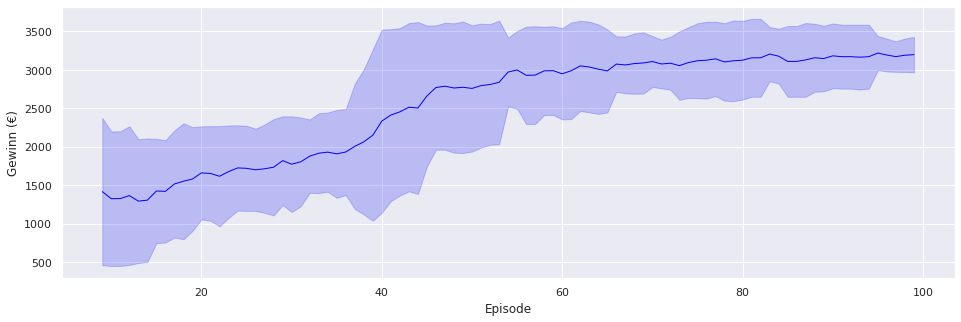

In [45]:
plot_return_trace(return_trace)

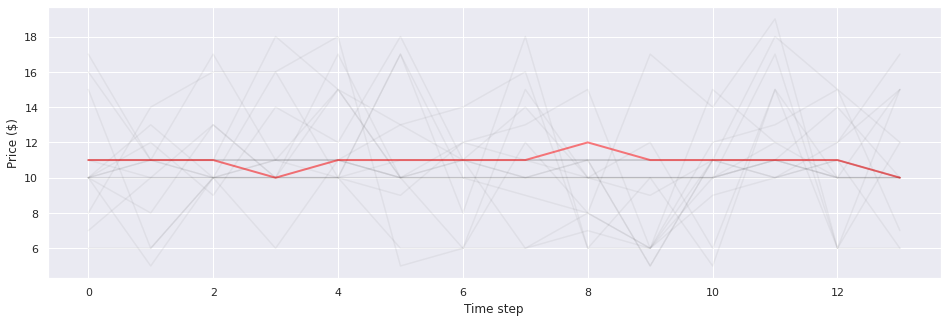

In [46]:
fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)

In [ ]:
p_trace

In [ ]:
stock_trace

In [ ]:
for profit in sorted(profit_response(s) for s in p_trace)[-10:]:
    print(f'Best profit results: {profit}')